### Initialization Bock

In [1]:
# Initialization
colab_run=False
anc_box= False
train=True
if colab_run==True:
  !pip install pydrive
  from pydrive.auth import GoogleAuth
  from pydrive.drive import GoogleDrive
  from google.colab import auth
  from oauth2client.client import GoogleCredentials

  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)

  import os, cv2
  from google.colab import drive
  drive.mount('/content/drive/')


from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.layers import concatenate
from matplotlib import pyplot as plt
import tensorflow.keras.backend as K
import tensorflow as tf
import numpy as np
import pickle
import os, cv2

#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"] = ""

# %matplotlib inline


C:\Users\irfan\Anaconda3\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\irfan\Anaconda3\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\irfan\Anaconda3\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\irfan\Anaconda3\envs\tf\lib\site-packages\tensorflow\python\framework\dty

### Configure Block

### Model Building Block

In [2]:
LABELS=['person', 'bird', 'cat', 'cow', 'dog', 'horse', 'sheep','aeroplane', 'bicycle',
         'boat', 'bus', 'car', 'motorbike', 'train', 'bottle', 'chair','dining table',
         'potted plant', 'sofa', 'tvmonitor']

IMAGE_H, IMAGE_W = 416, 416
GRID_H,  GRID_W  = 13 , 13
BOX              = 5
CLASS            = len(LABELS)
CLASS_WEIGHTS    = np.ones(CLASS, dtype='float32')
OBJ_THRESHOLD    = 0.3#0.5
NMS_THRESHOLD    = 0.3#0.45
#ANCHORS          = [0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828]
ANCHORS          = [ 4.469053,2.148582,10.548851,5.381520,11.420664,9.961033,6.517299,3.699693,2.469196,1.599054]
#ANCHORS=[13,13]
NO_OBJECT_SCALE  = 1.0
OBJECT_SCALE     = 5.0
COORD_SCALE      = 1.0
CLASS_SCALE      = 1.0

batch_size       =10
WARM_UP_BATCHES  = 0
TRUE_BOX_BUFFER  = 50


In [3]:
# the function to implement the orgnization layer (thanks to github.com/allanzelener/YAD2K)
def space_to_depth_x2(x):
    return tf.space_to_depth(x, block_size=2)

def build_model():
  input_image = Input(shape=(IMAGE_H, IMAGE_W, 3))
  true_boxes  = Input(shape=(1, 1, 1, TRUE_BOX_BUFFER , 4))

  # Layer 1
  x = Conv2D(32, (3,3), strides=(1,1), padding='same', name='conv_1', use_bias=False)(input_image)
  x = BatchNormalization(name='norm_1')(x)
  x = LeakyReLU(alpha=0.1)(x)
  x = MaxPooling2D(pool_size=(2, 2))(x)

  # Layer 2
  x = Conv2D(64, (3,3), strides=(1,1), padding='same', name='conv_2', use_bias=False)(x)
  x = BatchNormalization(name='norm_2')(x)
  x = LeakyReLU(alpha=0.1)(x)
  x = MaxPooling2D(pool_size=(2, 2))(x)

  # Layer 3
  x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_3', use_bias=False)(x)
  x = BatchNormalization(name='norm_3')(x)
  x = LeakyReLU(alpha=0.1)(x)

  # Layer 4
  x = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_4', use_bias=False)(x)
  x = BatchNormalization(name='norm_4')(x)
  x = LeakyReLU(alpha=0.1)(x)

  # Layer 5
  x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_5', use_bias=False)(x)
  x = BatchNormalization(name='norm_5')(x)
  x = LeakyReLU(alpha=0.1)(x)
  x = MaxPooling2D(pool_size=(2, 2))(x)

  # Layer 6
  x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_6', use_bias=False)(x)
  x = BatchNormalization(name='norm_6')(x)
  x = LeakyReLU(alpha=0.1)(x)

  # Layer 7
  x = Conv2D(128, (1,1), strides=(1,1), padding='same', name='conv_7', use_bias=False)(x)
  x = BatchNormalization(name='norm_7')(x)
  x = LeakyReLU(alpha=0.1)(x)

  # Layer 8
  x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_8', use_bias=False)(x)
  x = BatchNormalization(name='norm_8')(x)
  x = LeakyReLU(alpha=0.1)(x)
  x = MaxPooling2D(pool_size=(2, 2))(x)

  # Layer 9
  x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_9', use_bias=False)(x)
  x = BatchNormalization(name='norm_9')(x)
  x = LeakyReLU(alpha=0.1)(x)

  # Layer 10
  x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_10', use_bias=False)(x)
  x = BatchNormalization(name='norm_10')(x)
  x = LeakyReLU(alpha=0.1)(x)

  # Layer 11
  x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_11', use_bias=False)(x)
  x = BatchNormalization(name='norm_11')(x)
  x = LeakyReLU(alpha=0.1)(x)

  # Layer 12
  x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_12', use_bias=False)(x)
  x = BatchNormalization(name='norm_12')(x)
  x = LeakyReLU(alpha=0.1)(x)

  # Layer 13
  x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_13', use_bias=False)(x)
  x = BatchNormalization(name='norm_13')(x)
  x = LeakyReLU(alpha=0.1)(x)

  skip_connection = x

  x = MaxPooling2D(pool_size=(2, 2))(x)

  # Layer 14
  x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_14', use_bias=False)(x)
  x = BatchNormalization(name='norm_14')(x)
  x = LeakyReLU(alpha=0.1)(x)

  # Layer 15
  x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_15', use_bias=False)(x)
  x = BatchNormalization(name='norm_15')(x)
  x = LeakyReLU(alpha=0.1)(x)

  # Layer 16
  x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_16', use_bias=False)(x)
  x = BatchNormalization(name='norm_16')(x)
  x = LeakyReLU(alpha=0.1)(x)

  # Layer 17
  x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_17', use_bias=False)(x)
  x = BatchNormalization(name='norm_17')(x)
  x = LeakyReLU(alpha=0.1)(x)

  # Layer 18
  x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_18', use_bias=False)(x)
  x = BatchNormalization(name='norm_18')(x)
  x = LeakyReLU(alpha=0.1)(x)

  # Layer 19
  x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_19', use_bias=False)(x)
  x = BatchNormalization(name='norm_19')(x)
  x = LeakyReLU(alpha=0.1)(x)

  # Layer 20
  x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_20', use_bias=False)(x)
  x = BatchNormalization(name='norm_20')(x)
  x = LeakyReLU(alpha=0.1)(x)

  # Layer 21
  skip_connection = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_21', use_bias=False)(skip_connection)
  skip_connection = BatchNormalization(name='norm_21')(skip_connection)
  skip_connection = LeakyReLU(alpha=0.1)(skip_connection)
  skip_connection = Lambda(space_to_depth_x2)(skip_connection)

  x = concatenate([skip_connection, x])

  # Layer 22
  x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_22', use_bias=False)(x)
  x = BatchNormalization(name='norm_22')(x)
  x = LeakyReLU(alpha=0.1)(x)

  if anc_box==True:
    # Layer 23
    x = Conv2D(BOX*(4 + 1 + CLASS), (1,1), strides=(1,1), padding='same', name='conv_23')(x)
    output = Reshape((GRID_H, GRID_W,BOX,4 + 1 + CLASS))(x)
  else :
    # Layer 23
    x = Conv2D((4 + 1 + CLASS), (1,1), strides=(1,1), padding='same', name='conv_23')(x)
    output = Reshape((GRID_H, GRID_W,4 + 1 + CLASS))(x)

  # small hack to allow true_boxes to be registered when Keras build the model 
  # for more information: https://github.com/fchollet/keras/issues/2790
  #output = Lambda(lambda args: args[0])([output, true_boxes])#Change :Hasib

  #model = Model([input_image, true_boxes], output)#Change :Hasib
  model = Model(input_image, output)
  return model
  #model.load_weights('/content/drive/My Drive/Data/yolo_net_ep500_act.h5')


class WeightReader:
    def __init__(self, weight_file):
        self.offset = 4
        self.all_weights = np.fromfile(weight_file, dtype='float32')
        
    def read_bytes(self, size):
        self.offset = self.offset + size
        return self.all_weights[self.offset-size:self.offset]
    
    def reset(self):
        self.offset = 4

def load_weights(model,path_wst):
  wt_path = path_wts                      
  weight_reader = WeightReader(wt_path)
  weight_reader.reset()
  nb_conv = 23

  for i in range(1, nb_conv+1):
      conv_layer = model.get_layer('conv_' + str(i))

      if i < nb_conv:
          norm_layer = model.get_layer('norm_' + str(i))

          size = np.prod(norm_layer.get_weights()[0].shape)

          beta  = weight_reader.read_bytes(size)
          gamma = weight_reader.read_bytes(size)
          mean  = weight_reader.read_bytes(size)
          var   = weight_reader.read_bytes(size)

          weights = norm_layer.set_weights([gamma, beta, mean, var])       

      if len(conv_layer.get_weights()) > 1:
          bias   = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
          kernel = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
          kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
          kernel = kernel.transpose([2,3,1,0])
          conv_layer.set_weights([kernel, bias])
      else:
          kernel = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
          kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
          kernel = kernel.transpose([2,3,1,0])
          conv_layer.set_weights([kernel])
  return model


def yolo_loss_0(y_true, y_pred):
        loss=0
      #for n in range(BATCH_SIZE):
        for i in range(GRID_H):
          for j in range(GRID_W):
            for k in range(0,6):
              temp=y_true[i,j,k]-y_pred[i,j,k]
              #temp=temp**2
              loss+=temp
              
        return loss 
def yolo_loss_1(y_true, y_pred):
      loss=0
          ### adjust w and h
      ob_mask= tf.expand_dims(y_true[..., 4], axis=-1)
      conf_mask=y_true[...,4]
      
      if anc_box==True:
        cell_x = tf.to_float(tf.reshape(tf.tile(tf.range(GRID_W), [GRID_H]), (1, GRID_H, GRID_W, 1, 1)))
        cell_y = tf.transpose(cell_x, (0,2,1,3,4))
        cell_grid = tf.tile(tf.concat([cell_x,cell_y], -1), [BATCH_SIZE, 1, 1, 5, 1])

        pred_xy = tf.sigmoid(y_pred[..., :2]) + cell_grid
        pred_wh = tf.exp(y_pred[..., 2:4]) * np.reshape(ANCHORS, [1,1,1,BOX,2])
      
      else:
        pred_xy=(y_pred[...,0:2])
        pred_wh=(y_pred[...,2:4])
      
      true_xy=y_true[...,0:2]
      true_wh=y_true[...,2:4]
      
      #pred_wh=tf.multiply(pred_wh,ob_mask)
      pred_conf=y_pred[...,4]
      ### adjust confidence
      true_wh_half = true_wh / 2.
      true_mins    = tf.subtract(true_xy,true_wh_half)
      true_maxes   = tf.add(true_xy,true_wh_half)
    
      pred_wh_half = pred_wh / 2.
      pred_mins    = tf.subtract(pred_xy,pred_wh_half)
      pred_maxes   = tf.add(pred_xy,pred_wh_half)       
    
      intersect_mins  = tf.maximum(pred_mins,  true_mins)
      intersect_maxes = tf.minimum(pred_maxes, true_maxes)
      intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
      intersect_areas = tf.multiply(intersect_wh[..., 0] , intersect_wh[..., 1])
    
      true_areas = tf.multiply(true_wh[..., 0] , true_wh[..., 1])
      pred_areas = tf.multiply(pred_wh[..., 0] , pred_wh[..., 1])

      union_areas =tf.subtract(tf.add(pred_areas,true_areas),intersect_areas)
      intersect_areas=tf.add(intersect_areas,1)
      union_areas=tf.add(union_areas,1)
      iou_scores  = tf.truediv(intersect_areas, union_areas)
      
      true_conf =tf.multiply( iou_scores,y_true[..., 4])
      
      loss_bb=tf.subtract(true_xy,pred_xy)
      loss_bb=tf.square(loss_bb)
      loss_bb=tf.multiply(loss_bb,ob_mask)
      loss_bb=tf.reduce_sum(loss_bb)
      loss_wh=tf.subtract((true_wh),(pred_wh))
      loss_wh=tf.square(loss_wh)
      loss_wh=tf.multiply(loss_wh,ob_mask)
      loss_wh=tf.reduce_sum(loss_wh)
      loss_conf=tf.subtract(true_conf,pred_conf)
      loss_conf=tf.square(loss_conf)
      loss_conf=tf.multiply(loss_conf,conf_mask)
      loss_conf=tf.reduce_sum(loss_conf)
      loss=loss_bb+loss_wh+loss_conf       
      return loss


In [4]:
def custom_loss(y_true, y_pred):
    mask_shape = tf.shape(y_true)[:4]
    
    cell_x = tf.to_float(tf.reshape(tf.tile(tf.range(GRID_W), [GRID_H]), (1, GRID_H, GRID_W, 1, 1)))
    cell_y = tf.transpose(cell_x, (0,2,1,3,4))

    cell_grid = tf.tile(tf.concat([cell_x,cell_y], -1), [BATCH_SIZE, 1, 1, 5, 1])
    
    coord_mask = tf.zeros(mask_shape)
    conf_mask  = tf.zeros(mask_shape)
    class_mask = tf.zeros(mask_shape)
    
    seen = tf.Variable(0.)
    total_recall = tf.Variable(0.)
    
    """
    Adjust prediction
    """
    ### adjust x and y      
    pred_box_xy = tf.sigmoid(y_pred[..., :2]) + cell_grid
    
    ### adjust w and h
    pred_box_wh = tf.exp(y_pred[..., 2:4]) * np.reshape(ANCHORS, [1,1,1,BOX,2])
    
    ### adjust confidence
    pred_box_conf = tf.sigmoid(y_pred[..., 4])
    
    ### adjust class probabilities
    pred_box_class = y_pred[..., 5:]
    
    """
    Adjust ground truth
    """
    ### adjust x and y
    true_box_xy = y_true[..., 0:2] # relative position to the containing cell
    
    ### adjust w and h
    true_box_wh = y_true[..., 2:4] # number of cells accross, horizontally and vertically
    
    ### adjust confidence
    true_wh_half = true_box_wh / 2.
    true_mins    = true_box_xy - true_wh_half
    true_maxes   = true_box_xy + true_wh_half
    
    pred_wh_half = pred_box_wh / 2.
    pred_mins    = pred_box_xy - pred_wh_half
    pred_maxes   = pred_box_xy + pred_wh_half       
    
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = true_box_wh[..., 0] * true_box_wh[..., 1]
    pred_areas = pred_box_wh[..., 0] * pred_box_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)
    
    true_box_conf = iou_scores * y_true[..., 4]
    
    ### adjust class probabilities
    true_box_class = tf.argmax(y_true[..., 5:], -1)
    
    """
    Determine the masks
    """
    ### coordinate mask: simply the position of the ground truth boxes (the predictors)
    coord_mask = tf.expand_dims(y_true[..., 4], axis=-1) * COORD_SCALE
    
    ### confidence mask: penelize predictors + penalize boxes with low IOU
    # penalize the confidence of the boxes, which have IOU with some ground truth box < 0.6
    '''
    true_xy = true_boxes[..., 0:2]
    true_wh = true_boxes[..., 2:4]
    
    true_wh_half = true_wh / 2.
    true_mins    = true_xy - true_wh_half
    true_maxes   = true_xy + true_wh_half
    
    pred_xy = tf.expand_dims(pred_box_xy, 4)
    pred_wh = tf.expand_dims(pred_box_wh, 4)
    
    pred_wh_half = pred_wh / 2.
    pred_mins    = pred_xy - pred_wh_half
    pred_maxes   = pred_xy + pred_wh_half    
    
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = true_wh[..., 0] * true_wh[..., 1]
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)

    best_ious = tf.reduce_max(iou_scores, axis=4) 
    conf_mask = conf_mask + tf.to_float(best_ious < 0.6) * (1 - y_true[..., 4]) * NO_OBJECT_SCALE
    '''
    # penalize the confidence of the boxes, which are reponsible for corresponding ground truth box
    conf_mask = conf_mask + y_true[..., 4] * OBJECT_SCALE
    
    ### class mask: simply the position of the ground truth boxes (the predictors)
    class_mask = y_true[..., 4] * tf.gather(CLASS_WEIGHTS, true_box_class) * CLASS_SCALE       
    '''
    """
    Warm-up training
    """
    no_boxes_mask = tf.to_float(coord_mask < COORD_SCALE/2.)
    seen = tf.assign_add(seen, 1.)
    
    true_box_xy, true_box_wh, coord_mask = tf.cond(tf.less(seen, WARM_UP_BATCHES), 
                          lambda: [true_box_xy + (0.5 + cell_grid) * no_boxes_mask, 
                                   true_box_wh + tf.ones_like(true_box_wh) * np.reshape(ANCHORS, [1,1,1,BOX,2]) * no_boxes_mask, 
                                   tf.ones_like(coord_mask)],
                          lambda: [true_box_xy, 
                                   true_box_wh,
                                   coord_mask])
    '''
    """
    Finalize the loss
    """
    nb_coord_box = tf.reduce_sum(tf.to_float(coord_mask > 0.0))
    nb_conf_box  = tf.reduce_sum(tf.to_float(conf_mask  > 0.0))
    nb_class_box = tf.reduce_sum(tf.to_float(class_mask > 0.0))
    
    loss_xy    = tf.reduce_sum(tf.square(true_box_xy-pred_box_xy)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_wh    = tf.reduce_sum(tf.square(true_box_wh-pred_box_wh)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_conf  = tf.reduce_sum(tf.square(true_box_conf-pred_box_conf) * conf_mask)  / (nb_conf_box  + 1e-6) / 2.
    loss_class = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=true_box_class, logits=pred_box_class)
    loss_class = tf.reduce_sum(loss_class * class_mask) / (nb_class_box + 1e-6)
    
    loss = loss_xy + loss_wh + loss_conf + loss_class
        
    return loss

### Data Ready Block

In [5]:
def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b

    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
             return 0
        else:
            return min(x2,x4) - x3          

def bbox_iou(box1, box2):
    box1_xmin,box1_ymin,box1_xmax,box1_ymax=box1
    box2_xmin,box2_ymin,box2_xmax,box2_ymax=box2
    intersect_w = _interval_overlap([box1_xmin, box1_xmax], [box2_xmin, box2_xmax])
    intersect_h = _interval_overlap([box1_ymin, box1_ymax], [box2_ymin, box2_ymax])  
    
    intersect = intersect_w * intersect_h

    w1, h1 = box1_xmax-box1_xmin, box1_ymax-box1_ymin
    w2, h2 = box2_xmax-box2_xmin, box2_ymax-box2_ymin
    
    union = w1*h1 + w2*h2 - intersect
    
    return float(intersect) / union
  
def Batch_Gen(train_imgs):
        n=len(train_imgs)
        x_batch = np.zeros((n,IMAGE_H, IMAGE_W,3),dtype=float)                         # input images
        #b_batch = np.zeros((r_bound - l_bound, 1     , 1     , 1    ,  self.config['TRUE_BOX_BUFFER'], 4))   # list of self.config['TRUE_self.config['BOX']_BUFFER'] GT boxes
        if anc_box==True:
          y_batch = np.zeros((n, GRID_H, GRID_W,BOX,4+1+len(LABELS)),dtype=np.float)                # desired network output
        else :
          y_batch = np.zeros((n, GRID_H, GRID_W,4+1+len(LABELS)),dtype=np.float)                # desired network output
        instance_count=0
        for train_instance in train_imgs:
            # augment input image and fix object's position and size
            #img, all_objs = self.aug_image(train_instance, jitter=self.jitter)
            image_name = train_instance['filename']
            img = cv2.imread(image_name)
            img = cv2.resize(img, (IMAGE_H,IMAGE_W))
            img = img[:,:,::-1]
            img_w=train_instance['height']
            img_h=train_instance['width']
            all_objs = train_instance['object']
            # construct output from object's x, y, w, h
            true_box_index = 0
            anchors = [[0, 0, ANCHORS[2*i], ANCHORS[2*i+1]] for i in range(int(len(ANCHORS)//2))]
            for obj in all_objs:
                no_gridx=float(IMAGE_W / GRID_W)
                no_gridy=float(IMAGE_H /GRID_H)
                if obj['xmax'] > obj['xmin'] and obj['ymax'] > obj['ymin'] and obj['name'] in LABELS:
                    center_x = .5*(obj['xmin'] + obj['xmax'])
                    center_x = center_x/no_gridx
                    center_y = .5*(obj['ymin'] + obj['ymax'])
                    center_y=center_y/no_gridy
                    grid_x = int(np.floor(center_x))
                    grid_y = int(np.floor(center_y))
                    #center_x-=grid_x
                    #center_y-=grid_y
                    if grid_x < GRID_W and grid_y < GRID_H:
                        obj_indx  = LABELS.index(obj['name'])
                        center_w = (obj['xmax'] - obj['xmin'])/no_gridx #/ (float(self.config['IMAGE_W'])# / self.config['GRID_W']) # unit: grid cell
                        center_h = (obj['ymax'] - obj['ymin'])/no_gridy #/ (float(self.config['IMAGE_H'])# / self.config['GRID_H']) # unit: grid cell
                        center_w=center_w
                        center_h=center_h
                        
                        box = [center_x, center_y, center_w, center_h]

                        # find the anchor that best predicts this box#Change :Hasib
                        best_anchor = -1
                        max_iou     = -1
                        
                        shifted_box = [0, 0, center_w, center_h]
                        
                        for i in range(len(anchors)):
                            anchor = anchors[i]
                            iou    = bbox_iou(shifted_box, anchor)
                            
                            if max_iou < iou:
                                best_anchor = i
                                max_iou     = iou
                      
                        # assign ground truth x, y, w, h, confidence and class probs to y_batch
                        if anc_box==True:
                          y_batch[instance_count, grid_y, grid_x, best_anchor,0:4] = box
                          y_batch[instance_count, grid_y, grid_x, best_anchor,4  ] = 1.
                          y_batch[instance_count, grid_y, grid_x, best_anchor,5+obj_indx] = 1
                        else :
                          y_batch[instance_count, grid_y, grid_x,0:4] = box
                          y_batch[instance_count, grid_y, grid_x,4  ] = 1.
                          y_batch[instance_count, grid_y, grid_x,5+obj_indx] = 1

                        # assign the true box to b_batch
                        #b_batch[instance_count, 0, 0, 0, true_box_index] = box#Change: Hasib
                        
                        #true_box_index += 1
                        #true_box_index = true_box_index % self.config['TRUE_BOX_BUFFER']
                            
            # assign input image to x_batch
            x_batch[instance_count] = img/255

            # increase instance counter in current batch
            instance_count += 1  

        #print(' new batch created', idx)

        return x_batch, y_batch

import csv

def read_data(dataset):
  f=open(dataset+'/label.csv')
  file=csv.reader(f,delimiter=',')
  data=[]
  i=0
  sc=416.0
  for line in file:
      dt=line
      H=dt[0]
      W=dt[1]
      xmin=(float(dt[2]))/sc
      ymin=(float(dt[3]))/sc
      xmax=(float(dt[4]))/sc
      ymax=(float(dt[5]))/sc

      output={
          'filename':dataset+'/images/'+str(i)+'.jpg',
          'height':H,
          'width':W,
          'object':[{'name':'None',
          'xmin':xmin*IMAGE_W,
          'ymin':ymin*IMAGE_H,
          'xmax':xmax*IMAGE_W,
          'ymax':ymax*IMAGE_H}]
          }

      data.append(output)
      i=i+1
  return data



In [6]:

if colab_run==True :data_dir='/content/drive/My Drive/CNN_Basic/'
else: data_dir=''
from xml.etree import ElementTree as ET

def read_content(xml_file: str):
    objs=[]
    tree = ET.parse(xml_file)
    root = tree.getroot()

    list_with_all_boxes = []
    filename = root.find('filename').text
    size=root.find('size')
    img_h=int(size.find('height').text)
    img_w=int(size.find('width').text)
    print(img_h)
    for boxes in root.iter('object'):
        
        name = boxes.find('name').text
        ymin, xmin, ymax, xmax = None, None, None, None
        
        for box in boxes.findall("bndbox"):
            ymin = int(box.find("ymin").text)
            xmin = int(box.find("xmin").text)
            ymax = int(box.find("ymax").text)
            xmax = int(box.find("xmax").text)
        wf=IMAGE_W/img_w
        hf=IMAGE_H/img_h
        obj={'name':name,
          'xmin':xmin*wf,
          'ymin':ymin*hf,
          'xmax':xmax*wf,
          'ymax':ymax*hf}
        objs.append(obj)
        
    out={
          'filename':data_dir+'VOC_Images/'+filename,
          'height':img_h,
          'width':img_w,
          'object':objs
    }
        
    return filename, list_with_all_boxes,out
  
import glob
import cv2
import pandas as pd
save=False
if save==True:
  fnames=[]
  all_data=[]
  i=0
  
  for file in glob.glob(data_dir+'Annotations/*'):
    i+=1
    print(i)
    _,_,obj=read_content(file)
    #print(data)
    #break
    #fname, boxes, objs = read_content(file)
    #fnames.append(fname)
    all_data.append(obj)
 
  #df=pd.DataFrame([fnames,obj_list],index=['fname','objs']).transpose()
  #df=df.sample(frac=1,random_state=10).reset_index(drop=True)
  #n=len(df)
  #split=int(0.8*n)
  #train_data=df.loc[:split]
  #val_data=df.loc[split:].reset_index(drop=True)
  import pickle
  f=open(data_dir+'_VOC_dfs','wb')
  pickle.dump(all_data,f)
  f.close()
import pickle
f=open(data_dir+'_VOC_dfs','rb')
all_data=pickle.load(f)
f.close()

### Train Block

In [7]:
def train_model(model):
  optimizer = Adam(lr=0.5e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
	#optimizer = SGD(lr=1e-4, decay=0.0005, momentum=0.9)
	#optimizer = RMSprop(lr=1e-4, rho=0.9, epsilon=1e-08, decay=0.0)
  model.compile(loss=yolo_loss_1, optimizer=optimizer,metrics=['accuracy'])
  if anc_box==True:
    model.compile(loss=custom_loss, optimizer=optimizer,metrics=['accuracy'])
  history=model.fit(x_train, y_train,batch_size=batch_size,epochs=50,validation_data=(x_test,y_test),shuffle=True)
	#history=model.fit_generator(generator= train_batch, 
						#steps_per_epoch  = len(train_batch), 
						#epochs           = 60, 
						#verbose          = 1,
						#validation_data  = valid_batch,
						#validation_steps = len(valid_batch),
						#callbacks        = [early_stop], 
						#max_queue_size   = 3)
  plt.plot(history.history['acc'])
  plt.plot(history.history['loss'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  return model


In [8]:
import numpy as np
#root='/content/drive/My Drive/Data/'
root=''
path_wts=root+'yolo.weights'
path_wts_final=root+'yolo_minimal_anc_500.h5'
#path_data=root+'np_500'
#path_pred=root+'/np_500/images/'
  
if train==True:
  #data=read_data(path_data)
  
  train_imgs=all_data[:400]
  valid_imgs=all_data[400:460]
  
  x_train,y_train = Batch_Gen(train_imgs)
  x_test,y_test = Batch_Gen(valid_imgs)
model=build_model()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 416, 416, 3)  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 416, 416, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
norm_1 (BatchNormalization)     (None, 416, 416, 32) 128         conv_1[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 416, 416, 32) 0           norm_1[0][0]                     
__________________________________________________________________________________________________
max_poolin

In [9]:
train_imgs[0]['filename']

'VOC_Images/000005.jpg'

Train on 400 samples, validate on 60 samples
Epoch 1/50
400/400 [==============================] - 24s 59ms/step - loss: 2202.6670 - acc: 0.4641 - val_loss: 973.0718 - val_acc: 0.2048
Epoch 2/50
400/400 [==============================] - 15s 38ms/step - loss: 327.8623 - acc: 0.3995 - val_loss: 517.5825 - val_acc: 0.3386
Epoch 3/50
400/400 [==============================] - 15s 39ms/step - loss: 160.0794 - acc: 0.3969 - val_loss: 399.4484 - val_acc: 0.3922
Epoch 4/50
400/400 [==============================] - 16s 39ms/step - loss: 99.8679 - acc: 0.3893 - val_loss: 344.0642 - val_acc: 0.3974
Epoch 5/50
400/400 [==============================] - 16s 39ms/step - loss: 75.5121 - acc: 0.3940 - val_loss: 320.5910 - val_acc: 0.4149
Epoch 6/50
400/400 [==============================] - 16s 39ms/step - loss: 59.1415 - acc: 0.3893 - val_loss: 295.3079 - val_acc: 0.4186
Epoch 7/50
400/400 [==============================] - 16s 39ms/step - loss: 42.2217 - acc: 0.3853 - val_loss: 270.6818 - val_acc:

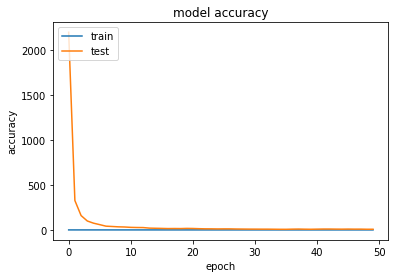

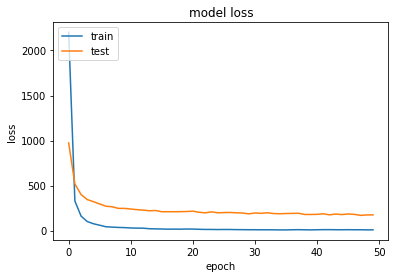

In [10]:
if train==True:
	model=load_weights(model,path_wts)
	model=train_model(model)
if train==False:
	model.load_weights(path_wts_final)

### Predicion Block

In [0]:
def _softmax(x, axis=-1, t=-100.):
    x = x - np.max(x)
    
    if np.min(x) < t:
        x = x/np.min(x)*t
        
    e_x = np.exp(x)
    
    return e_x / e_x.sum(axis, keepdims=True)

def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

def decode_netout_anc(netout, anchors, nb_class, obj_threshold=0.3, nms_threshold=0.3):
    #grid_h, grid_w, nb_box = netout.shape[:3]
    grid_h, grid_w = netout.shape[:2]

    boxes = []
    
    # decode the output by the network
    netout[..., 4]  = _sigmoid(netout[..., 4])
    netout[..., 5:] = netout[..., 4][..., np.newaxis] * _softmax(netout[..., 5:])
    netout[..., 5:] *= netout[..., 5:] > obj_threshold
    
    for row in range(grid_h):
        for col in range(grid_w):
            for b in range(BOX):
                # from 4th element onwards are confidence and class classes
                classes = netout[row,col,b,5:]
                #classes = netout[row,col,5:]
                confidence = netout[row,col,b,4]
                if np.sum(classes) > 0:
                    # first 4 elements are x, y, w, and h
                    #x, y, w, h = netout[row,col,b,:4]
                    x, y, w, h = netout[row,col,b,:4]
                    #print(col,_sigmoid(x-col),row,_sigmoid(y),w,h)
                    x = (col + _sigmoid(x)) / grid_w # center position, unit: image width
                    y = (row + _sigmoid(y)) / grid_h # center position, unit: image height
                    w = ANCHORS[2 * b + 0] * np.exp(w) / grid_w # unit: image width
                    h = ANCHORS[2 * b + 1] * np.exp(h) / grid_h # unit: image height
                    #print(x,y,w,h)
                    classes=np.argmax(classes)
                    
                    box = (x-w/2, y-h/2, x+w/2, y+h/2, confidence, classes)
                    box = (x-w/2, y-h/2, x+w/2, y+h/2, confidence, classes)
                    if abs(box[0])<=1 and abs(box[1])<=1 and box[2]<=1 and box[3]<=1 :
                      if (box[0])>=0 and (box[1])>=0 and box[2]>=0 and box[3]>=0 :
                        boxes.append(box)
                    

                        
    indx=np.argsort([box[4] for box in boxes])
    f_boxes=[]
    #indx=reversed(indx)
    if len(indx)>=3:
      for i in range(1,2):
        ind=indx[-1*i]
        f_boxes.append(boxes[ind])
    else:
      f_boxes=boxes
    return f_boxes    
    
def decode_netout_1(netout, anchors, nb_class, obj_threshold=0.3, nms_threshold=0.3):
    #grid_h, grid_w, nb_box = netout.shape[:3]
    grid_h, grid_w = netout.shape[:2]

    boxes = []
    
    # decode the output by the network
    netout[..., 4]  = _sigmoid(netout[..., 4])
    netout[..., 5:] = netout[..., 4][..., np.newaxis] * _softmax(netout[..., 5:])
    netout[..., 5:] *= netout[..., 5:] > obj_threshold
    print('A')
    for row in range(grid_h):
        for col in range(grid_w):
            #for b in range(BOX):
                # from 4th element onwards are confidence and class classes
                classes = netout[row,col,5:]
                #classes = netout[row,col,5:]
                confidence = netout[row,col,4]
                if np.sum(classes) > 0:
                    # first 4 elements are x, y, w, and h
                    #x, y, w, h = netout[row,col,b,:4]
                    x, y, w, h = netout[row,col,:4]
                    #print(col,_sigmoid(x-col),row,_sigmoid(y),w,h)
                    x = x*(32/416) # center position, unit: image width
                    y = y*(32/416) # center position, unit: image height
                    w = w*(32/416) # unit: image width
                    h = h*(32/416) # unit: image height
                    #print(x,y,w,h)
                    classes=np.argmax(classes)
                    
                    box = (x-w/2, y-h/2, x+w/2, y+h/2, confidence, classes)
                    if abs(box[0])<=1 and abs(box[1])<=1 and box[2]<=1 and box[3]<=1 :
                      if (box[0])>=0 and (box[1])>=0 and box[2]>=0 and box[3]>=0 :
                        boxes.append(box)
                    
                      
    
    indx=np.argsort([box[4] for box in boxes])
    # remove the boxes which are less likely than a obj_threshold
    #obj_threshold=0
    #print(boxes)
    #for box in boxes:
    #  if box[4]>obj_threshold:
    #      obj_threshold=box[4]
    #boxes = [box for box in boxes if box[4] >= obj_threshold-0.1]
    
    f_boxes=[]
    #indx=reversed(indx)
    if len(indx)>=3:
      for i in range(1,2):
        ind=indx[-1*i]
        f_boxes.append(boxes[ind])
    else:
      f_boxes=boxes
    print('B')
    return f_boxes    

def draw_boxes_1(image, boxes, labels,t_lbl=None):
    image_h, image_w, _ = image.shape

    for box in boxes:
        xmin = int(box[0]*image_w)
        ymin = int(box[1]*image_h)
        xmax = int(box[2]*image_w)
        ymax = int(box[3]*image_h)
        x_off=20
        y_off=20
        print(xmin,ymin,xmax,ymax)
        print(box)
        cv2.rectangle(image, (xmin-x_off,ymin-y_off), (xmax+x_off,ymax+y_off), (255,0,0), 3)
        cv2.rectangle(image, (xmin,ymin), (xmax,ymax), (0,255,0), 3)
        if t_lbl !=None:
          cv2.rectangle(image, (t_lbl[0],t_lbl[1]), (t_lbl[2],t_lbl[3]), (0,0,255), 3)
        cv2.putText(image, 
                    labels[box[5]] + ' ' + str(box[4]), 
                    (xmin, ymin - 13), 
                    cv2.FONT_HERSHEY_SIMPLEX, 
                    1e-3 * image_h, 
                    (0,255,0), 1)
        
    return image

"""# Perform detection on image"""
error=0
count=0
import pandas as pd
lbls=pd.read_csv(path_data+'/label.csv',names=[0,1,2,3,4,5])
  
for i in range(400,450):
  count+=1
  image = cv2.imread(path_pred+str(i)+'.jpg')
  H_off=int(image.shape[0]*0.1)
  W_off=int(image.shape[1]*0.1)
  #image=image[H_off:-1*H_off,W_off:-1*W_off,:]
  dummy_array = np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4))

  

  input_image = cv2.resize(image, (416, 416))
  input_image = input_image / 255.
  input_image = input_image[:,:,::-1]
  input_image = np.expand_dims(input_image, 0)

  netout = model.predict(input_image)
  #print(netout[0,:,:,0:2])


  if anc_box==True:
    boxes = decode_netout_anc(netout[0], 
                        obj_threshold=.60,
                        nms_threshold=.90,
                        anchors=ANCHORS, 
                        nb_class=CLASS)
  else:
    boxes = decode_netout_1(netout[0], 
                        obj_threshold=0.60,
                        nms_threshold=.90,
                        anchors=ANCHORS, 
                        nb_class=CLASS)
  
  true_lb=list(lbls.loc[i,2:5])
  err=np.sum(np.square(np.array(true_lb)-np.array(boxes[0][:4])*416))
  if err<100:
    error+=err
  else:
    error+=100
  #boxex.appned(true_lb)
  image = draw_boxes_1(image, boxes, LABELS,true_lb)
  plt.figure(figsize=(10,10))
  plt.imshow(image[:,:,::-1]); plt.show()
  print(err)
print('mean error',error/count)

Output hidden; open in https://colab.research.google.com to view.

In [12]:
model.save('yolo_400.h5')

In [0]:
import pandas as pd
lbls=pd.read_csv(path_data+'/label.csv',names=[0,1,2,3,4,5])
true_lb=list(lbls.loc[0,0:5])
true_lb